In [1]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

from MotorNet.plants import PlantWrapper
from MotorNet.plants.skeletons import PointMass
from MotorNet.plants.muscles import ReluMuscle
from MotorNet.utils.plotor import plot_pos_over_time
from MotorNet.nets.losses import empty_loss, position_loss, activation_squared_loss
from MotorNet.nets.layers import GRUController
from MotorNet.nets.callbacks import BatchLogger
from MotorNet.tasks import TaskDelayedReach
from MotorNet.nets. custommodels import MotorNetModel
from dPCA.dPCA import dPCA

%load_ext autoreload
%autoreload 2

# tf.debugging.enable_check_numerics()
print('tensorflow version: ' + tf.__version__)


tensorflow version: 2.3.0


In [2]:
arm = PointMass(space_dim=2, proprioceptive_delay=0.04, visual_delay=0.13)
plant = PlantWrapper(skeleton=arm, muscle_type=ReluMuscle())

plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[5, 5], [0, 0]], name='ur', max_isometric_force=500)
plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-5, 5], [0, 0]], name='ul', max_isometric_force=500)
plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[5, -5], [0, 0]], name='dr', max_isometric_force=500)
plant.add_muscle(path_fixation_body=[0, 1], path_coordinates=[[-5, -5], [0, 0]], name='dl', max_isometric_force=500)


simulation duration: 0.2809999999590218 sec


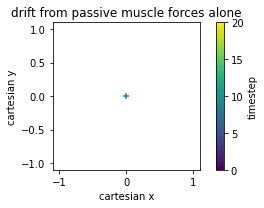

In [3]:
# create initial conditions
sho, elb = np.meshgrid(
    np.linspace(plant.pos_lower_bound[0], plant.pos_upper_bound[0], 21).astype('float32'),
    np.linspace(plant.pos_lower_bound[1], plant.pos_upper_bound[1], 21).astype('float32'))
z = tf.zeros_like(sho.reshape(-1))
ex = tf.ones((sho.size, plant.n_muscles)) * [0, 0, 0, 0]
state0 = plant.get_initial_state(joint_state=tf.stack([sho.reshape(-1), elb.reshape(-1), z, z], axis=1))


# 200 ms simulation to assess drift
c_results = state0[1][:, tf.newaxis, :]
m_results = state0[-2][:, tf.newaxis, :, :]
states = state0
start = time.monotonic()
for _ in range(int(0.2 / plant.dt)):
    states = plant(ex, states[0], states[2], states[3])
    c_results = tf.concat([c_results, states[1][:, tf.newaxis, :]], axis=1)
    m_results = tf.concat([m_results, states[-2][:, tf.newaxis, :, :]], axis=1)
print('simulation duration: ' + str(time.monotonic() - start) + ' sec')

# plot results
plt.figure(figsize=(5, 3)).set_tight_layout(True)
plot_pos_over_time(cart_results=c_results)
plt.title('drift from passive muscle forces alone')
plt.show()

gstate = state0[-1].numpy().reshape((21, 21, 4, plant.n_muscles))
mstate = state0[-2].numpy().reshape((21, 21, 4, plant.n_muscles))


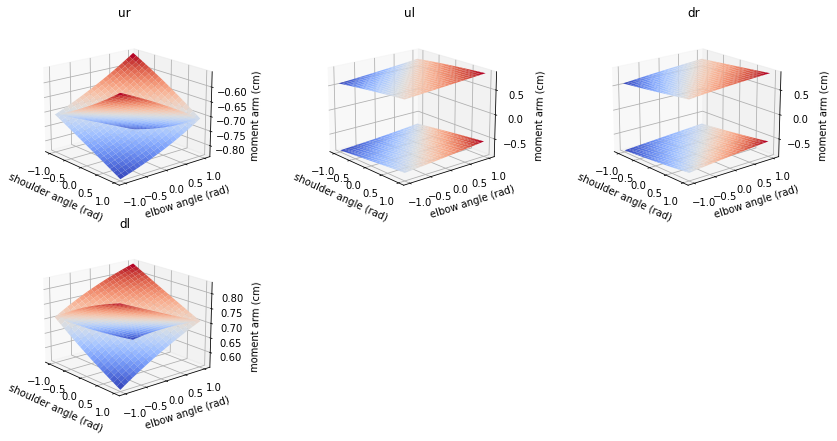

In [4]:

fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('xkcd:white')
fig.set_tight_layout(True)
for m in range(plant.n_muscles):
    ax = fig.add_subplot(2, 3, m+1, projection='3d')
    ax.plot_surface(sho, elb, gstate[:, :, 2, m], cmap=plt.get_cmap('coolwarm'))
    ax.plot_surface(sho, elb, gstate[:, :, 3, m], cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('moment arm (cm)')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(plant.muscle_name[m])
plt.show()


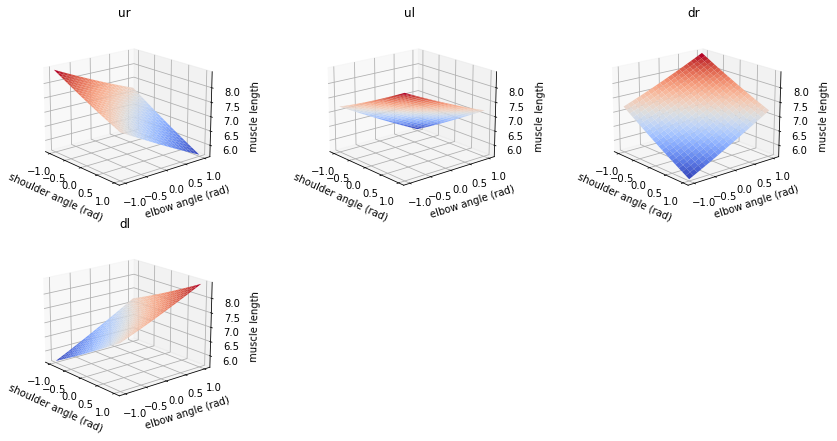

In [5]:
fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('xkcd:white')
fig.set_tight_layout(True)
for m in range(plant.n_muscles):
    ax = fig.add_subplot(2, 3, m+1, projection='3d')
    ax.plot_surface(sho, elb, gstate[:, :, 0, m], cmap=plt.get_cmap('coolwarm'))
    ax.set_xlabel('shoulder angle (rad)')
    ax.set_ylabel('elbow angle (rad)')
    ax.set_zlabel('muscle length')
    ax.view_init(18, -40)
    ax.locator_params(nbins=6)
    plt.title(plant.muscle_name[m])
plt.show()



In [6]:
cell = GRUController(plant=plant, n_units=50, kernel_regularizer=10**-6, name='cell')

# declare inputs
targets = Input((None, plant.output_dim,), name='target')
state0 = [Input((plant.output_dim, ), name='joint0'),
          Input((plant.output_dim, ), name='cartesian0'),
          Input((plant.muscle_state_dim, plant.n_muscles, ), name='muscle0'),
          Input((plant.geometry_state_dim, plant.n_muscles, ), name='geometry0'),
          Input((plant.n_muscles * 2, plant.proprioceptive_delay, ), name='proprio_feedback0'),
          Input((plant.space_dim, plant.visual_delay, ), name='visual_feedback0')]
state0.extend([Input((n, ), name='gru' + str(k) + '_hidden0') for k, n in enumerate(cell.n_units)])

# wrap cell in an RNN layer
rnn = tf.keras.layers.RNN(cell=cell, return_sequences=True, name='RNN')
states_out = rnn(targets, initial_state=state0)
task = TaskDelayedReach(cell, delay_range=[30, 60])
control_rnn = MotorNetModel(inputs=[targets, state0], outputs=states_out, name='controller', task=task)

# link outputs to their loss
losses = {name: empty_loss() for name in states_out.keys()}
loss_weights = {name: 0. for name in states_out.keys()}
losses['cartesian position'] = position_loss()
losses['muscle state'] = activation_squared_loss(plant.Muscle.max_iso_force)
loss_weights['cartesian position'] = 1
loss_weights['muscle state'] = 0.1


# and compile
control_rnn.compile(optimizer=tf.optimizers.Adam(clipnorm=1.), loss=losses, loss_weights=loss_weights)
batchlog_callback = BatchLogger()
control_rnn.summary()

losses


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "controller"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target (InputLayer)             [(None, None, 4)]    0                                            
___________________________________________________________________________________

{'joint position': <function MotorNet.nets.losses.empty_loss.<locals>.loss(y_true, y_pred)>,
 'cartesian position': <function MotorNet.nets.losses.position_loss.<locals>.loss(y_true, y_pred)>,
 'muscle state': <function MotorNet.nets.losses.activation_squared_loss.<locals>.loss(y_true, y_pred)>,
 'geometry state': <function MotorNet.nets.losses.empty_loss.<locals>.loss(y_true, y_pred)>,
 'proprioceptive feedback': <function MotorNet.nets.losses.empty_loss.<locals>.loss(y_true, y_pred)>,
 'visual feedback': <function MotorNet.nets.losses.empty_loss.<locals>.loss(y_true, y_pred)>,
 'gru_hidden0': <function MotorNet.nets.losses.empty_loss.<locals>.loss(y_true, y_pred)>}

In [7]:
dataset_size = 2000 * 32
n_t = int(1 / plant.dt)

with tf.device('/cpu:0'):
    [inputs, targets, init_states] = task.generate(batch_size=dataset_size, n_timesteps=n_t)
    # init_states = cell.get_initial_state(batch_size=dataset_size)
    # goal_states = plant.draw_random_uniform_states(batch_size=dataset_size)
    # target = plant.state2target(state=plant.joint2cartesian(goal_states), n_timesteps=n_t)
    control_rnn.fit([inputs, init_states], targets, epochs=1, batch_size=32, verbose=1, callbacks=[batchlog_callback], shuffle=False)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2000/2000 [==============================] - 266s 133ms/step - loss: 0.0991 - RNN_loss: 0.0972 - RNN_1_loss: 0.0000e+00 - RNN_2_loss: 0.0000e+00 - RNN_3_loss: 0.0000e+00 - RNN_4_loss: 0.0186 - RNN_5_loss: 0.0000e+00 - RNN_6_loss: 0.0000e+00

In [8]:
targets

<tf.Tensor: shape=(64000, 100, 4), dtype=float32, numpy=
array([[[ 0.11898279, -0.29834747,  0.        ,  0.        ],
        [ 0.11898279, -0.29834747,  0.        ,  0.        ],
        [ 0.11898279, -0.29834747,  0.        ,  0.        ],
        ...,
        [ 0.39587474,  0.57876325,  0.        ,  0.        ],
        [ 0.39587474,  0.57876325,  0.        ,  0.        ],
        [ 0.39587474,  0.57876325,  0.        ,  0.        ]],

       [[ 0.11898279, -0.29834747,  0.        ,  0.        ],
        [ 0.11898279, -0.29834747,  0.        ,  0.        ],
        [ 0.11898279, -0.29834747,  0.        ,  0.        ],
        ...,
        [ 0.15702009, -0.71646214,  0.        ,  0.        ],
        [ 0.15702009, -0.71646214,  0.        ,  0.        ],
        [ 0.15702009, -0.71646214,  0.        ,  0.        ]],

       [[ 0.11898279, -0.29834747,  0.        ,  0.        ],
        [ 0.11898279, -0.29834747,  0.        ,  0.        ],
        [ 0.11898279, -0.29834747,  0.       

last loss value = 0.09909793734550476


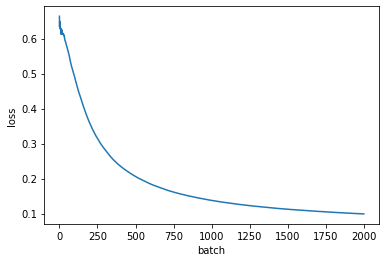

In [9]:
if 'loss' in batchlog_callback.history:
    last_loss = batchlog_callback.history['loss'][-1]
    print('last loss value = ' + str(last_loss))
    plt.plot(batchlog_callback.history['loss'])
    plt.xlabel('batch')
    plt.ylabel('loss')
    # plt.semilogy()
    plt.show()


In [10]:
def grad(model, model_inputs, y_true, loss):
    with tf.GradientTape() as tape:
        model_pred = model(model_inputs, training=False)
        y_pred = model_pred['cartesian position']
        loss_value = loss(y_true=y_true, y_pred=y_pred)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

init_states_sample = cell.get_initial_state(batch_size=1)
goal_states = plant.draw_random_uniform_states(batch_size=1)
target_sample = plant.state2target(state=plant.joint2cartesian(goal_states), n_timesteps=n_t)

loss_val, gradients = grad(control_rnn, [target_sample, init_states_sample], target_sample, position_loss())
# gradients



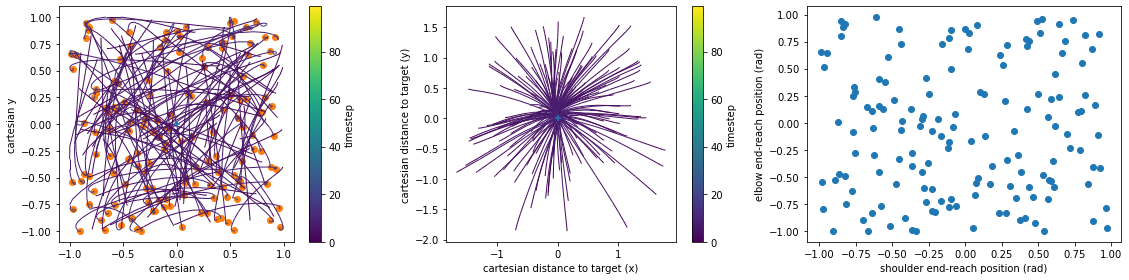

In [11]:
init_states_sample = cell.get_initial_state(batch_size=150)
goal_states = plant.draw_random_uniform_states(batch_size=150)
target_sample = plant.state2target(state=plant.joint2cartesian(goal_states), n_timesteps=n_t)

results = control_rnn([target_sample, init_states_sample], training=False)
j_results = results['joint position']
c_results = results['cartesian position']
m_results = results['muscle state']

plt.figure(figsize=(16, 4)).set_tight_layout(True)
plt.subplot(131)
plot_pos_over_time(cart_results=c_results)
plt.scatter(target_sample[:, 0, 0], target_sample[:, 0, 1])

plt.subplot(132)
plot_pos_over_time(cart_results=c_results - target_sample)
plt.xlabel('cartesian distance to target (x)')
plt.ylabel('cartesian distance to target (y)')

plt.subplot(133)
plt.scatter(j_results[:,-1,0].numpy().T, j_results[:,-1,1].numpy().T)
plt.xlabel('shoulder end-reach position (rad)')
plt.ylabel('elbow end-reach position (rad)')
plt.show()


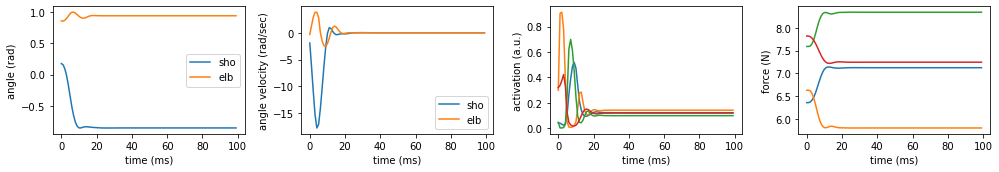

In [12]:
trial = 10
plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

plt.subplot(141)
plt.plot(j_results[trial, :, 0].numpy().squeeze(), label='sho')
plt.plot(j_results[trial, :, 1].numpy().squeeze(), label='elb')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('angle (rad)')

plt.subplot(142)
plt.plot(j_results[trial, :, 2].numpy().squeeze(), label='sho')
plt.plot(j_results[trial, :, 3].numpy().squeeze(), label='elb')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('angle velocity (rad/sec)')

plt.subplot(143)
plt.plot(m_results[trial, :, 0, :].numpy().squeeze())
plt.xlabel('time (ms)')
plt.ylabel('activation (a.u.)')

plt.subplot(144)
plt.plot(m_results[trial, :, 1, :].numpy().squeeze())
plt.xlabel('time (ms)')
plt.ylabel('force (N)')

plt.show()



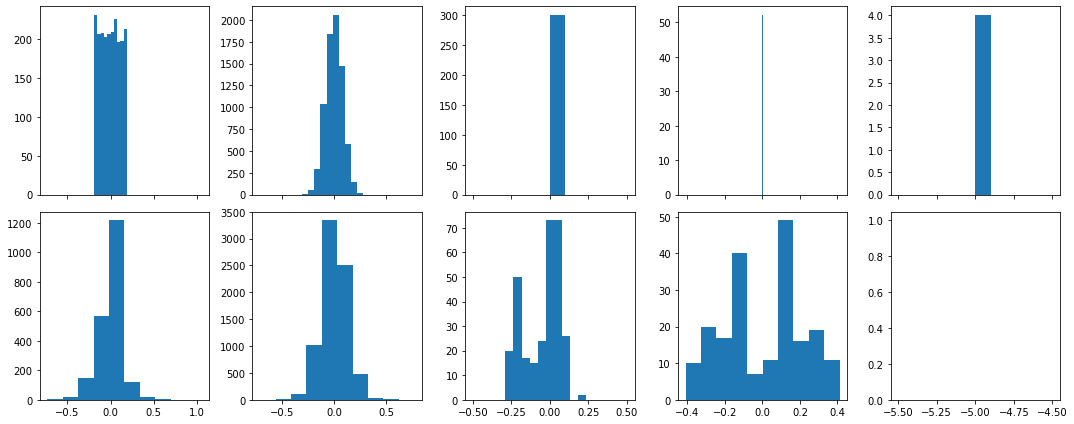

In [13]:
if len(batchlog_callback.weights_log) > 0:
    w0 = batchlog_callback.weights_log[0]
    w1 = batchlog_callback.weights_log[-1]

    fig, axs = plt.subplots(nrows=2, ncols=len(w0), sharex='col')
    fig.set_tight_layout(tight=True)
    fig.set_size_inches((15, 6))

    for n in range(len(w0)):
        weights_ini = w0[n].numpy()
        weights_fin = w1[n].numpy()

        if len(weights_ini.shape) < 10:
            axs[0,n].hist(weights_ini.flatten())
            axs[1,n].hist(weights_fin.flatten())
        else:
            axs[0,n].imshow(weights_ini, interpolation='none')
            axs[1,n].imshow(weights_fin, interpolation='none')

    plt.show()

(150, 100, 50)
(100, 50)
(100, 2)


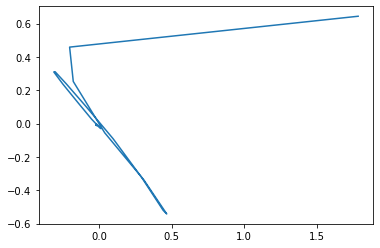

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

a = results['gru_hidden0'].numpy()
print(a.shape)
x = np.mean(a, axis=0)
# x = StandardScaler().fit_transform(x)
print(x.shape)
# x = x.reshape((150,40,-1))
# print(x.shape)
# x = np.stack([PCA(n_components=2).fit_transform(x[:,k,:]) for k in range(x.shape[1])])
x = PCA(n_components=2).fit_transform(x)
print(x.shape)
n=40
plt.plot(x[:,0], x[:,1])
plt.show()

In [15]:

a = results['gru_hidden0'].numpy()
print(a.shape)
x = np.mean(a, axis=0)
print(x.shape)
x = dPCA(labels="tn", n_components=2).fit_transform(a)
print(x.keys())



(150, 100, 50)
(100, 50)
dict_keys(['t', 'n', 'tn'])


In [16]:
### To apply a set of weights from a previous iteration weight set w1
# control_rnn.get_layer('RNN').set_weights([w.numpy() for w in w1])

### save model
# name = '50gru_1e-2dt_6muscles_weights'
# control_rnn.save_weights(os.getcwd() + '/saved_models/' + name)

















